In [2]:
import pyogrio
import pandas as pd
import pickle
from zipfile import ZipFile
import tempfile
import numpy as np
from pathlib import Path
import os
from collections import defaultdict
pd.set_option('display.max_columns',None)

# requires local installation of ireiat package using 
from ireiat.util.cacheable import CACHE_PATH

### Purpose
Given the FAF5 regional association with counties and the county population, create an OD matrix (state_orig, county_orig, state_dest, county_dest)=tons

In [3]:
TARGET_FIELD = 'tons_2022'
TOLERANCE = 1e-6

In [4]:
county_pop_pdf = pd.read_csv(CACHE_PATH / 'data/raw/us_county_pop.csv',dtype={'STATE':str,'COUNTY':str})

In [5]:
with open(CACHE_PATH / 'data/transformed/faf_zone_id_to_state_county_id.pickle','rb') as fp:
    faf_id_to_county_id_map = pickle.load(fp)

In [6]:
actual_state_county_to_pop_map = dict()
for row in county_pop_pdf.loc[county_pop_pdf['COUNTY']!='000'].itertuples(): # ignore state totals
    actual_state_county_to_pop_map[(row.STATE,row.COUNTY)]=row.POPESTIMATE2022

In [10]:
faf_id_to_county_id_population_map = defaultdict(dict)

# look up the county population within each faf zone
for faf_id, vals in faf_id_to_county_id_map.items():
    for (state_id, county_id), pct_county_in_faf in vals.items():
        faf_id_to_county_id_population_map[faf_id][(state_id, county_id)] = actual_state_county_to_pop_map[(state_id, county_id)]*pct_county_in_faf

In [11]:
faf_total_population_map = dict()
for faf_id, vals_dict in faf_id_to_county_id_population_map.items():
    faf_total_population_map[faf_id] = sum(vals_dict.values())

# check that the totals are equal
assert sum(actual_state_county_to_pop_map.values()) == sum(faf_total_population_map.values())

In [12]:
# determine the percentage of the faf demand that should be allocated to the county based on the allocation metric of interest
faf_id_to_county_percent_map = defaultdict(dict)
for faf_id, vals in faf_id_to_county_id_population_map.items():
    for (state_id, county_id), population_portion in vals.items():
        faf_id_to_county_percent_map[faf_id][(state_id, county_id)]=population_portion/faf_total_population_map[faf_id]

# confirm that all the faf ids have a "total" allocation that sums to 1 (within some tolerance)
assert all([abs(sum(pop_map.values())-1)<TOLERANCE for pop_map in faf_id_to_county_percent_map.values()])

In [13]:
target_path = CACHE_PATH / 'data/raw/faf5_demand.zip'
zip = ZipFile(target_path)
with tempfile.TemporaryDirectory() as tmpdirname:
    zip.extractall(path=tmpdirname)
    target_csvs = [f for f in zip.namelist() if f.endswith('csv')]
    faf_pdf = pd.read_csv(zip.open(target_csvs[0]),dtype={'dms_orig':str, 'dms_dest':str})
    zip.close()

In [10]:
# faf_mode_map = {
#     1:  'Truck',
#     2:	'Rail',
#     3:	'Water',
#     4:	'Air (include truck-air)',
#     5:	'Multiple modes & mail',
#     6:	'Pipeline',
#     7:	'Other and unknown',
#     8:	'No domestic mode',
# }

In [15]:
is_by_truck = faf_pdf['dms_mode']==1 # by truck
faf_truck_pdf = faf_pdf.loc[is_by_truck]
total_road_tons_od_pdf = faf_truck_pdf.groupby(['dms_orig','dms_dest'],as_index=False)[[TARGET_FIELD]].sum()

In [16]:
faf_truck_pdf.sample(10)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2023,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,value_2017,value_2018,value_2019,value_2020,value_2021,value_2022,value_2023,value_2025,value_2030,value_2035,value_2040,value_2045,value_2050,current_value_2018,current_value_2019,current_value_2020,current_value_2021,current_value_2022,tmiles_2017,tmiles_2018,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2023,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
694363,801.0,269,559,NaN,3.0,1,NaN,18,2,3,6.300147,4.814187,1.714411,8.213343,15.561633,15.772813,11.717456,11.410623,10.621532,9.189011,7.949693,6.877521,5.949953,2.720182,3.579980,1.014487,3.887642,7.191268,5.533109,5.059185,4.926706,4.586004,3.967492,3.432398,2.969472,2.568980,4.720767,1.192062,3.562042,11.787611,14.826946,2.474291,1.890702,0.673310,3.225671,6.111606,6.194544,4.601861,4.481357,4.171453,3.608851,3.122127,2.701047,2.336758
680547,807.0,012,124,NaN,3.0,1,NaN,13,2,4,0.001495,0.016119,0.000000,0.000000,0.000000,0.000000,0.001168,0.001296,0.001615,0.001930,0.002307,0.002757,0.003295,0.002760,0.001409,0.000000,0.000000,0.000000,0.000000,0.002156,0.002393,0.002981,0.003563,0.004259,0.005090,0.006084,0.001425,0.000000,0.000000,0.000000,0.000000,0.000750,0.008092,0.000000,0.000000,0.000000,0.000000,0.000586,0.000651,0.000811,0.000969,0.001158,0.001384,0.001654
1242465,807.0,012,219,NaN,3.0,1,NaN,35,2,4,0.011278,0.000000,0.001173,0.000000,0.000000,0.000000,0.013746,0.014829,0.017048,0.019683,0.022757,0.026348,0.030546,0.040182,0.000000,0.013105,0.000000,0.000000,0.000000,0.048975,0.052834,0.060739,0.070127,0.081081,0.093874,0.108831,0.000000,0.013391,0.000000,0.000000,0.000000,0.006759,0.000000,0.000703,0.000000,0.000000,0.000000,0.008238,0.008887,0.010217,0.011796,0.013638,0.015790,0.018306
1977055,NaN,241,341,805.0,NaN,1,4.0,28,3,2,0.000000,0.000000,0.000000,0.000000,0.001843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1117338,806.0,451,472,NaN,3.0,1,NaN,33,2,4,2.173416,2.938991,3.686995,3.956335,5.891032,7.889251,2.565278,2.725807,3.057695,3.377713,3.722043,4.074885,4.446624,7.656420,6.158386,6.313461,4.883138,8.710678,11.506597,9.036855,9.602362,10.771521,11.898870,13.111861,14.354839,15.664385,6.464401,6.778970,5.232529,10.970387,17.162842,1.203077,1.626855,2.040906,2.189997,3.260934,4.367031,1.419989,1.508849,1.692562,1.869706,2.060307,2.255620,2.461393
29638,NaN,341,459,NaN,NaN,1,NaN,6,1,4,10.005353,9.978124,10.152298,9.903354,9.882898,10.372549,11.412003,13.198744,15.312864,17.051565,18.917355,20.857613,23.224525,14.998311,14.957493,15.218585,14.845411,14.814748,15.548748,17.106919,19.785296,22.954423,25.560785,28.357657,31.266159,34.814230,15.283707,15.759472,15.456975,16.121409,19.439415,7.127024,7.107628,7.231696,7.054368,7.039797,7.388586,8.129011,9.401744,10.907676,12.146190,13.475231,14.857318,16.543319
1816353,NaN,491,487,802.0,NaN,1,1.0,22,3,6,0.038651,0.201990,0.034820,0.107736,0.028678,0.136059,0.016788,0.017097,0.018326,0.019733,0.021308,0.023073,0.025052,0.019586,0.102661,0.017697,0.054757,0.014576,0.069152,0.008507,0.008664,0.009286,0.009999,0.010798,0.011692,0.012695,0.111545,0.019143,0.055635,0.019142,0.124191,0.057796,0.302040,0.052068,0.161100,0.042883,0.203452,0.025103,0.025565,0.027403,0.029507,0.031862,0.034501,0.037461
1589527,NaN,551,341,805.0,NaN,1,3.0,4,3,5,0.001547,0.010186,0.003806,0.000000,0.020884,0.002874,0.002733,0.002836,0.002998,0.003338,0.003722,0.004154,0.004643,0.008013,0.011829,0.004992,0.000000,0.024512,0.002486,0.014156,0.014690,0.015531,0.017291,0.019277,0.021518,0.0

In [17]:
total_road_tons_od_pdf

,dms_orig,dms_dest,tons_2022
0,011,011,35094.705274
1,011,012,920.946425
2,011,019,10282.662724
3,011,020,0.048017
4,011,041,43.631707
...,...,...,...
16789,560,539,49.695447
16790,560,540,10.490821
16791,560,551,8.950731
16792,560,559,52.667418


In [13]:
%%time
# create a (state_orig, county_orig, state_dest, county_dest) => tons map
county_od = defaultdict(float)
for row in total_road_tons_od_pdf.itertuples():
    constituent_orig_counties_map = faf_id_to_county_percent_map[row.dms_orig]
    constituent_dest_counties_map = faf_id_to_county_percent_map[row.dms_dest]
    for (state_orig, county_orig), pct_in_county_orig in constituent_orig_counties_map.items():
        for (state_dest, county_dest), pct_in_county_dest in constituent_dest_counties_map.items():
            county_od[(state_orig, county_orig, state_dest, county_dest)] += getattr(row,TARGET_FIELD)*pct_in_county_orig*pct_in_county_dest

assert abs(total_road_tons_od_pdf[TARGET_FIELD].sum()-sum(county_od.values()))<TOLERANCE

CPU times: total: 7.38 s
Wall time: 7.39 s


In [14]:
len(county_od)

9835245

In [15]:
county_od_tuples = [(*k, v) for k,v in county_od.items()]

In [16]:
county_od_pdf = pd.DataFrame(county_od_tuples,columns=['state_orig','county_orig','state_dest','county_dest','tons'])

In [17]:
county_od_pdf.describe()

,tons
count,9.835245e+06
mean,1.285232e+00
std,7.460633e+01
min,0.000000e+00
25%,1.938726e-03
50%,1.108630e-02
75%,6.775824e-02
max,8.467397e+04


In [18]:
county_od_pdf

,state_orig,county_orig,state_dest,county_dest,tons
0,01,009,01,009,63.080793
1,01,009,01,037,10.775631
2,01,009,01,121,85.543626
3,01,009,01,115,99.564878
4,01,009,01,043,96.101964
...,...,...,...,...,...
9835240,56,015,56,033,20.340211
9835241,56,015,56,027,1.508278
9835242,56,015,56,039,14.757680
9835243,56,015,56,035,5.553380


In [19]:
county_od_pdf['tons'].quantile(.98)

5.305011000119845

In [20]:
non_zero_county_od_pdf = county_od_pdf.loc[county_od_pdf['tons']>0].sort_values('tons')

In [21]:
non_zero_county_od_pdf['cum_tons'] = non_zero_county_od_pdf['tons'].cumsum()

<Axes: >

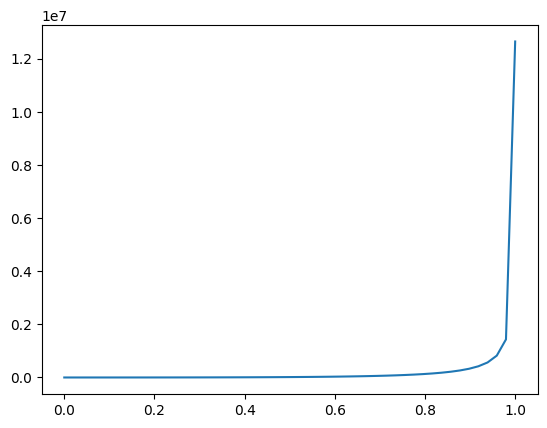

In [22]:
non_zero_county_od_pdf['cum_tons'].quantile(q=np.linspace(0,1,50)).plot()

In [27]:
# save as a parquet file to reduce file size
target_path = CACHE_PATH / 'data/transformed/county_od.parquet'
Path(os.path.dirname(target_path)).mkdir(parents=True,exist_ok=True)
county_od_pdf.to_parquet(target_path)